# Python: Group Average Treatment Effects (GATEs) for IRM models

In this simple example, we illustrate how the [DoubleML](https://docs.doubleml.org/stable/index.html) package can be used to estimate group average treatment effects in the [DoubleMLIRM](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-models-irm) model.

In [1]:
import numpy as np
import pandas as pd
import doubleml as dml

from doubleml.irm.datasets import make_heterogeneous_data

## Data

We define a data generating process to create synthetic data to compare the estimates to the true effect. The data generating process is based on the Monte Carlo simulation from [Oprescu et al. (2019)](http://proceedings.mlr.press/v97/oprescu19a.html).

The documentation of the data generating process can be found [here](https://docs.doubleml.org/stable/api/datasets.html#dataset-generators). In this example the true effect depends only the first covariate $X_0$ and takes the following form

$$
\theta_0(X) = \exp(2X_0) + 3\sin(4X_0).
$$

In [2]:
np.random.seed(42)
data_dict = make_heterogeneous_data(
    n_obs=500,
    p=10,
    support_size=5,
    n_x=1,
    binary_treatment=True,
)
data = data_dict['data']
print(data.head())

          y    d       X_0       X_1       X_2       X_3       X_4       X_5  \
0  6.114530  1.0  0.925248  0.180575  0.567945  0.915488  0.033946  0.697420   
1  5.580922  1.0  0.474214  0.862043  0.844549  0.319100  0.828915  0.037008   
2  1.278434  0.0  0.696289  0.339875  0.724767  0.065356  0.315290  0.539491   
3  1.794805  0.0  0.615863  0.232959  0.024401  0.870099  0.021269  0.874702   
4  6.178169  1.0  0.350712  0.767188  0.401931  0.479876  0.627505  0.873677   

        X_6       X_7       X_8       X_9  
0  0.297349  0.924396  0.971058  0.944266  
1  0.596270  0.230009  0.120567  0.076953  
2  0.790723  0.318753  0.625891  0.885978  
3  0.528937  0.939068  0.798783  0.997934  
4  0.984083  0.768273  0.417767  0.421357  


The generated dictionary also contains the true individual effects saved in the key `effects`.

In [3]:
ite = data_dict['effects']
print(ite[:5])

[4.770944   5.4235839  5.07202564 5.30917769 4.97441062]


The goal is to estimate the average treatment effect for different groups based on the covariate $X_0$. The groups can be specified as [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) with boolean columns. We consider the following three groups

In [4]:
groups = pd.DataFrame(
    np.column_stack((data['X_0'] <= 0.3,
                     (data['X_0'] > 0.3) & (data['X_0'] <= 0.7),
                     data['X_0'] > 0.7)),
    columns=['Group 1', 'Group 2', 'Group 3'])
print(groups.head())

   Group 1  Group 2  Group 3
0    False    False     True
1    False     True    False
2    False     True    False
3    False     True    False
4    False     True    False


The true effects (still including sampling uncertainty) are given by

In [5]:
true_effects = [ite[groups[group]].mean() for group in groups.columns]
print(true_effects)

[np.float64(2.906716732639898), np.float64(5.223485956098176), np.float64(4.827938162750831)]


## Interactive Regression Model (IRM)
The first step is to fit a [DoubleML IRM Model](https://docs.doubleml.org/stable/guide/models.html#interactive-regression-models-irm) to the data.

In [6]:
data_dml_base = dml.DoubleMLData(
    data,
    y_col='y',
    d_cols='d'
)

In [7]:
# First stage estimation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
ml_g = RandomForestRegressor(n_estimators=500)
ml_m = RandomForestClassifier(n_estimators=500)

np.random.seed(42)

dml_irm = dml.DoubleMLIRM(data_dml_base,
                          ml_g=ml_g,
                          ml_m=ml_m,
                          n_folds=5)
print("Training IRM Model")
dml_irm.fit()

print(dml_irm.summary)

Training IRM Model


       coef   std err          t  P>|t|     2.5 %    97.5 %
d  4.482349  0.086826  51.624206    0.0  4.312172  4.652526


## Group Average Treatment Effects (GATEs)
To calculate GATEs just call the ``gate()`` method and supply the DataFrame with the group definitions and the ``level`` (with default of ``0.95``). Remark that for straightforward interpretation of the GATEs the groups should be mutually exclusive.

In [8]:
gate = dml_irm.gate(groups=groups)
print(gate.confint(level=0.95))

            2.5 %    effect    97.5 %
Group 1  2.701491  3.016702  3.331913
Group 2  5.097140  5.314781  5.532421
Group 3  4.412864  4.669562  4.926260


The confidence intervals above are point-wise, but by setting the option ``joint`` and providing a number of bootstrap repetitions ``n_rep_boot``.

In [9]:
ci = gate.confint(level=0.95, joint=True, n_rep_boot=1000)
print(ci)

            2.5 %    effect    97.5 %
Group 1  2.441311  3.016702  3.592093
Group 2  4.917497  5.314781  5.712065
Group 3  4.200982  4.669562  5.138142


Finally, let us plot the estimates together with the true effect within each group.

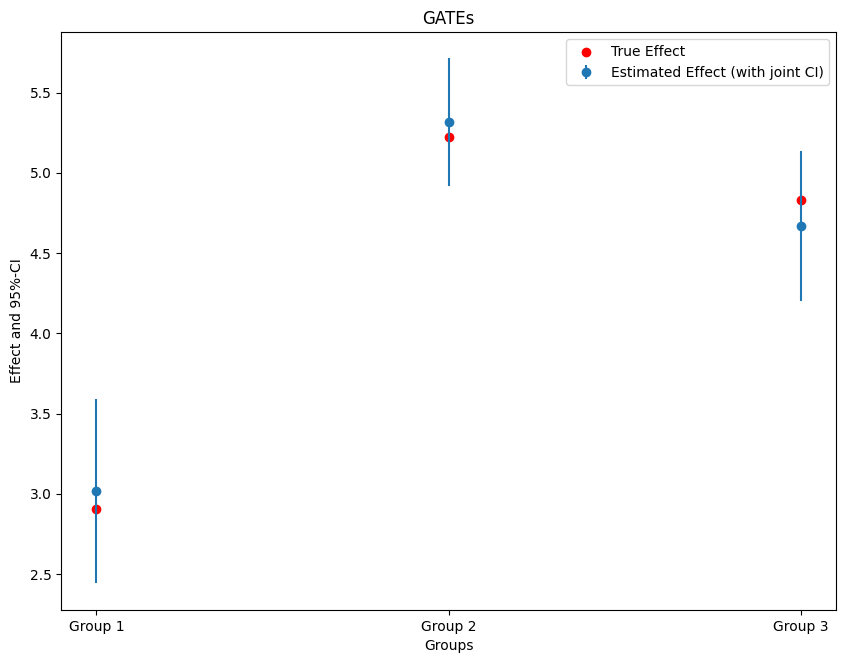

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10., 7.5

errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors, label='Estimated Effect (with joint CI)')

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group 1', 'Group 2', 'Group 3'], y=true_effects, c='red', label='True Effect')

plt.title('GATEs')
plt.xlabel('Groups')
plt.legend()
_ = plt.ylabel('Effect and 95%-CI')

It is also possible to supply disjoint groups as a single vector (still as a data frame). Remark the slightly different name.

In [11]:
groups =  pd.DataFrame(columns=['Group'], index=range(data['X_0'].shape[0]), dtype=str)
for i, x_i in enumerate(data['X_0']):
    if x_i <= 0.3:
         groups.loc[i, 'Group'] = '1'
    elif (x_i > 0.3) & (x_i <= 0.7):
         groups.loc[i, 'Group'] = '2'
    else:
         groups.loc[i, 'Group'] = '3'

print(groups.head())

  Group
0     3
1     2
2     2
3     2
4     2


This time lets consider pointwise confidence intervals.

In [12]:
gate = dml_irm.gate(groups=groups)
ci = gate.confint()
print(ci)

            2.5 %    effect    97.5 %
Group_1  2.701491  3.016702  3.331913
Group_2  5.097140  5.314781  5.532421
Group_3  4.412864  4.669562  4.926260


The coefficients of the best linear predictor can be seen via the summary (the values can be accessed through the underlying model ``.blp_model``).

In [13]:
print(gate.summary)

             coef   std err          t          P>|t|    [0.025    0.975]
Group_1  3.016702  0.160825  18.757663   1.676093e-78  2.701491  3.331913
Group_2  5.314781  0.111043  47.862274   0.000000e+00  5.097140  5.532421
Group_3  4.669562  0.130971  35.653424  2.085279e-278  4.412864  4.926260


Remark that the confidence intervals in the summary are slightly smaller, since they are not based on the White's heteroskedasticity robus standard errors.

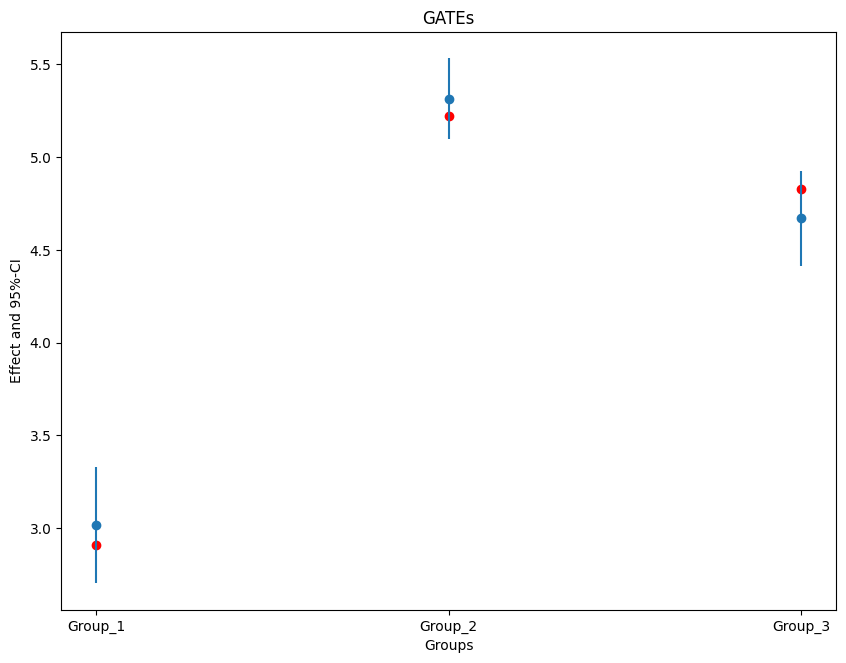

In [14]:
errors = np.full((2, ci.shape[0]), np.nan)
errors[0, :] = ci['effect'] - ci['2.5 %']
errors[1, :] = ci['97.5 %'] - ci['effect']

#add true effect
ax = plt.subplot(1, 1, 1)
ax.scatter(x=['Group_1', 'Group_2', 'Group_3'], y=true_effects, c='red', label='True Effect')

plt.errorbar(ci.index, ci.effect, fmt='o', yerr=errors)
plt.title('GATEs')
plt.xlabel('Groups')
_ =  plt.ylabel('Effect and 95%-CI')